Perfom all the Inports and forget about it

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

#Plot Graph
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

#font = {'size'   : 44}
#plt.rc('font', **font)


#Const
ZB_IOTG_ID = 0
MT_SNS_ID = 1
PLG_ID = 2
LED_ID = 3
UNLABLED_TRAFFIC = 4

RND_STATE = 42

DEBUG = 1

In [2]:
#Function Definition for Dataset

def data_balance(df,is_over=0):
    #Data balancing
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from collections import Counter
    train_res = None
    labels = None
    if is_over:
        #OverSampling
        resampler = RandomOverSampler(random_state=42)
        train_res, labels = resampler.fit_resample(df, df.addr)
        if DEBUG: print(f"Training target statistics: {Counter(labels)}")
    else:
        #UnderSampling
        resampler = RandomUnderSampler(random_state=42)
        train_res, labels = resampler.fit_resample(df, df.addr)
        if DEBUG: print(f"Training target statistics: {Counter(labels)}")
    return train_res, labels

def feat_select(train_res,feat_to_keep=None):
    #Train features selection
    train_res=train_res.drop('addr', axis=1)
    train_res=train_res.drop('time', axis=1)
    train_res.fillna(0,inplace=True)

    #Drop unwanted feat
    
    train_df=train_res
    if feat_to_keep is not None: train_df=train_res[feat_to_keep]

    if DEBUG: train_df.head()
    return train_df


In [3]:
import copy as cp
from typing import Tuple
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

def kfold_predict(train_df,labels,model,k_fold=10):
    
    X = train_df.to_numpy()
    y = labels.to_numpy()
    
        # Define the cross-validation strategy
    kfold = KFold(n_splits=k_fold, shuffle=True)
    
    actual_classes, predicted_classes, predicted_proba = cross_val_predict(model=model, kfold=kfold, X=X, y=y)
    return actual_classes, predicted_classes, predicted_proba

def kfold_stats(train_df,labels,model,k_fold=10):
    
    X = train_df.to_numpy()
    y = labels.to_numpy()
    
    # Define arrays to store the accuracy and f1 scores for each fold
    acc_scores = []
    f1_scores = []
    
    # Define the cross-validation strategy
    kfold = KFold(n_splits=k_fold, shuffle=True)
    
    # Perform cross-validation
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

    # Print the mean accuracy and f1 scores
    tmp_acc= np.mean(acc_scores)
    tmp_f1 = np.mean(f1_scores)  
    
    return tmp_acc, tmp_f1
    
#Index Optimization
def find_idx_KNN(train_df,labels,l_min=1,l_max=100,metric='accuracy',use_k_fold=False):
    #Setup
    best_val=0
    index=0
    
    X = train_df.to_numpy()
    y = labels.to_numpy()
    
    
    for i in range(l_min,l_max):
        # Create KNN classifier
        model = KNeighborsClassifier(n_neighbors = i)
        # Fit the classifier to the data

        # Define arrays to store the accuracy and f1 scores for each fold
        acc_scores = []
        f1_scores = []
        
        if use_k_fold:
            # Define the cross-validation strategy
            kfold = KFold(n_splits=10, shuffle=True)

            # Perform cross-validation
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc_scores.append(accuracy_score(y_test, y_pred))
                f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

        else:
            X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size = 0.25, random_state = 42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred, average="weighted"))
            
        
        # Print the mean accuracy and f1 scores
        tmp_acc= np.mean(acc_scores)
        tmp_f1 = np.mean(f1_scores)

        if metric == 'accuracy' and tmp_acc > best_val:
            best_val=tmp_acc
            index=i
        elif metric == 'f1' and tmp_f1 > best_val:
            best_val=tmp_f1
            index=i
            
            
    if DEBUG: print(f"{index},{metric}:{best_val}")
    return index



def find_idx_RF(train_df,labels,l_min=1,l_max=100,metric='accuracy',use_k_fold=False):
    #Setup
    best_val=0
    index=0
    
    X = train_df.to_numpy()
    y = labels.to_numpy()
    
    
    for i in range(l_min,l_max):
        # Create KNN classifier
        model = RandomForestClassifier(n_estimators=i, random_state=RND_STATE)
        # Fit the classifier to the data

        # Define arrays to store the accuracy and f1 scores for each fold
        acc_scores = []
        f1_scores = []
        
        if use_k_fold:
            # Define the cross-validation strategy
            kfold = KFold(n_splits=10, shuffle=True)

            # Perform cross-validation
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc_scores.append(accuracy_score(y_test, y_pred))
                f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

        else:
            X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size = 0.25, random_state = 42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc_scores.append(accuracy_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred, average="weighted"))
            
        
        # Print the mean accuracy and f1 scores
        tmp_acc= np.mean(acc_scores)
        tmp_f1 = np.mean(f1_scores)

        # Print the mean accuracy and f1 scores
        tmp_acc= np.mean(acc_scores)
        tmp_f1 = np.mean(f1_scores)

        if metric == 'accuracy' and tmp_acc > best_val:
            best_val=tmp_acc
            index=i
        elif metric == 'f1' and tmp_f1 > best_val:
            best_val=tmp_f1
            index=i
            
            
    if DEBUG: print(f"{index},{metric}:{best_val}")
    return index



Plot Helpers

In [4]:

import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, normalize=False, cmap=plt.cm.Blues, classes=['$\it{True}$','$\it{False}$'],ax=None,fig=None):
    
    """
    Plot confusion matrix.
    :param y_true: ground-truth labels
    :type y_true: list
    :param y_pred: predicted labels
    :type y_pred: list
    :param normalize: if set to True, normalise the confusion matrix.
    :type normalize: bool
    :param cmap: matplotlib cmap to be used for plot
    :type cmap:
    :return:
    """
 
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    # classes = ['$\it{Real}$','$\it{Fake}$']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, clim=(0,1))
    
    # Print the side Bar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params()
    
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           )
    ax.set_xlabel('$\mathrm{Predicted\;label}$')
    ax.set_ylabel('$\mathrm{True\;label}$')
    if classes is not None:
        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)
    
        ax.set_xticklabels(['$\mathrm{' + str(c) + '}$' for c in classes])
        ax.set_yticklabels(['$\mathrm{' + str(c) + '}$' for c in classes])
        
    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #          rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    #Define manual value for confusion Matrix
    
    #cm[2,3] = 0.02
    #cm[0,0] = 0.94
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format('$\mathrm{' + str(format(cm[i, j], fmt)) + '}$'),
                    ha="center", va="center",
                    color="white" if np.array(cm[i, j]) > thresh else "black")
            
    # Make a smaller and tighter version of the plot
    #fig.tight_layout()
    
    plt.show()

    return ax


def rename_column(col_name):
    col_name = col_name.replace("_data", "")
    col_name = col_name.replace("tot_", "")
    col_name = col_name.replace("inter_time", "IAT")
    col_name = col_name.replace("length", "pck_lgth")
    col_name = col_name.replace("payload_pck", "payload")
    col_name = col_name.replace("_", " ")
    col_name = col_name.title()
    col_name = col_name.replace("Iat", "IAT")
    return col_name


def plot_feat_bar(feat_importance,ax):
    arr = np.array(feat_importance)
    arr = arr.transpose()
    val=np.zeros(len(arr[1]))
    for k in range(0,len(arr[1])):
        val[k]=float(arr[1][k])

    arr[0] = [rename_column(col) for col in arr[0]]
    x_pos = np.arange(len(arr[0]))


    
    ax.bar(x_pos , val, align='center' ,width = 0.6)
    
    ax.set(xticks=x_pos, xticklabels=arr[0])

    
    ax.set_xticklabels(['$\mathrm{' + str(c) + '}$' for c in arr[0]], rotation=45, ha='right')
    ax.set_ylabel('$\mathrm{Importance\;}$')#, fontsize=14)
    ax.set_xlabel('$\mathrm{Features\;}$')#, fontsize=14)

    #fig.tight_layout()
    plt.show()


SONOFF Dataset

In [5]:
#Import and cleaning df

df = pd.read_csv ('/home/antonio/PCAP Repo/ML/gen_TW_5.csv')
df = df.astype({'addr':'int'})
a_df=df.query("addr<999999")

df = pd.read_csv ('/home/antonio/PCAP Repo/ML/gen_TW_5_2.csv')
df = df.astype({'addr':'int'})
b_df=df.query("addr<999999")

df = pd.concat([a_df,b_df])
df=b_df
#Label df

mot_sens_id = int(0x80a5)
plug_id = int(0xf3df)
led_1_id = int(0xf0bd)
led_2_id = int(0x5cb2)
zigbee_pan_c = int(0x0000)
#Make

df.loc[df.eval("addr==@zigbee_pan_c"),'addr']=ZB_IOTG_ID
df.loc[df.eval("addr==@mot_sens_id"),'addr']=MT_SNS_ID
df.loc[df.eval("addr==@plug_id"),'addr']=PLG_ID
df.loc[df.eval("addr==@led_1_id"),'addr']=LED_ID
df.loc[df.eval("addr==@led_2_id"),'addr']=LED_ID

#df.loc[df.eval("not (addr==@ZB_IOTG_ID or addr==@MT_SNS_ID or addr==@PLG_ID or addr==@LED_ID)"),'addr']=ZB_IOTG_ID
df=df.query("addr==@ZB_IOTG_ID or addr==@MT_SNS_ID or addr==@PLG_ID or addr==@LED_ID")

if DEBUG: df['addr'].value_counts()

#Prepare Dataset for ML
train_df_sonoff , labels_sonoff = data_balance(df)

feat_to_keep = ['tot_mean_length','tot_mean_payload_data_length','tot_mean_inter_time','in_mean_length','in_mean_payload_data_length','out_mean_length']

train_df_sonoff = feat_select(train_df_sonoff ,feat_to_keep)
if DEBUG: train_df_sonoff.head()
        
# Split the Dataset
train_features, test_features, train_labels, test_labels = train_test_split(train_df_sonoff, labels_sonoff, test_size = 0.25, random_state = 42)

features_test_1 = test_features
labels_test_1 = test_labels 


Training target statistics: Counter({0: 56, 1: 56, 2: 56, 3: 56})


KNN Classifier Sonof

KNN IDX = 1
acc, f1: (0.674308300395257, 0.6551209188519207)
Accuracy RF: 0.6785714285714286
              precision    recall  f1-score   support

           0       0.35      0.60      0.44        10
           1       0.95      1.00      0.97        18
           2       0.64      0.56      0.60        16
           3       0.83      0.42      0.56        12

    accuracy                           0.68        56
   macro avg       0.69      0.64      0.64        56
weighted avg       0.73      0.68      0.68        56

Jaccard_Score: 0.5603982483681732


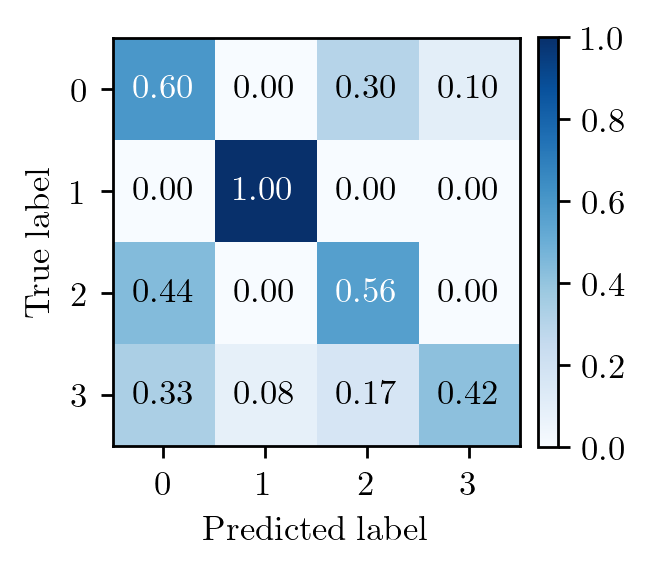

<AxesSubplot: xlabel='$\\mathrm{Predicted\\;label}$', ylabel='$\\mathrm{True\\;label}$'>

In [6]:
index_knn = 1 #8 #19 OnlyB 1
train_df=train_df_sonoff
labels=labels_sonoff

# Solve Optimization IDX process

#index_knn=find_idx_KNN(train_df , labels, use_k_fold=True)

if DEBUG: print(f"KNN IDX = {index_knn}")

# Create KNN classifier
model = KNeighborsClassifier(n_neighbors = index_knn)
# Fit the classifier to the data
model.fit(train_features, train_labels)


## Predicted probabilities

pred_prob=model.predict_proba(test_features)

predictions = model.predict(test_features)

print("acc, f1:",kfold_stats(train_df,labels_sonoff,model,k_fold=10))

# Use the forest's predict method on the test data
print("Accuracy RF:", metrics.accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("Jaccard_Score:", jaccard_score(test_labels, predictions, average='weighted'))


fig, ax = plt.subplots(figsize=(2.3,2.3),dpi=250) 

plot_confusion_matrix(test_labels,predictions, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)




RF Sonof Classfier

RF IDX = 82
acc, f1: (0.7102766798418971, 0.7003699347424645)
Accuracy RF: 0.9107142857142857
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.95      1.00      0.97        18
           2       1.00      0.94      0.97        16
           3       0.90      0.75      0.82        12

    accuracy                           0.91        56
   macro avg       0.90      0.90      0.89        56
weighted avg       0.92      0.91      0.91        56

Jaccard_Score: 0.8443464430306535


/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


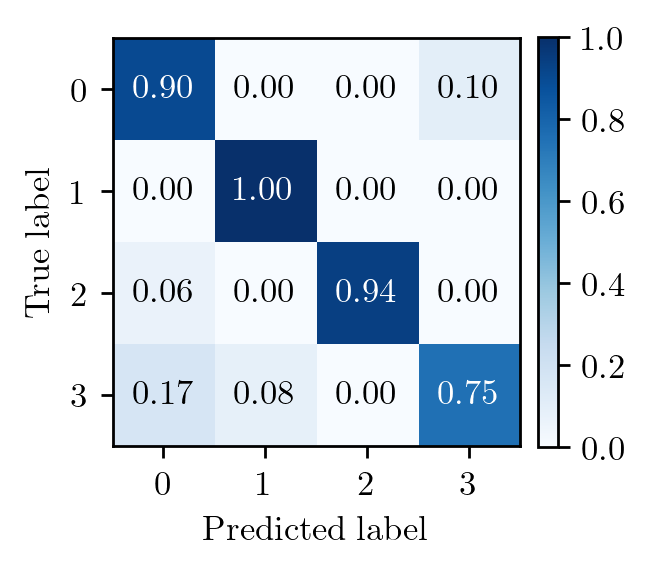

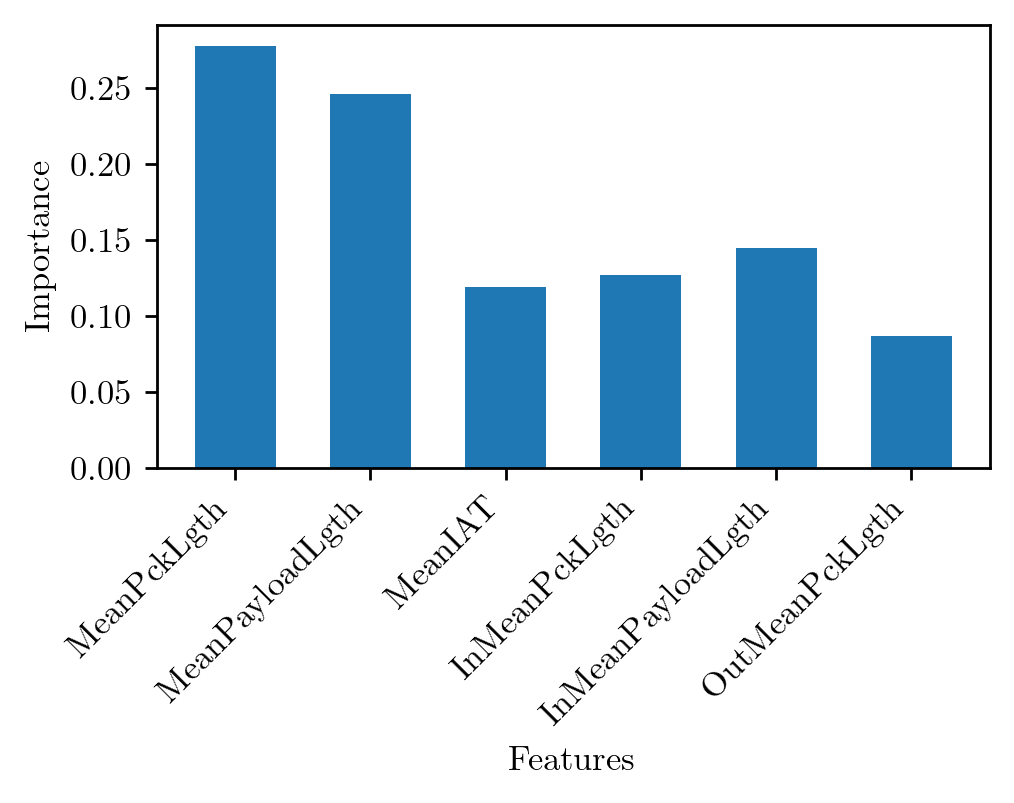

In [7]:
train_df = train_df_sonoff
labels = labels_sonoff

index_rf = 82 #17 #63 OnlyB #13 #82

# Solve Optimization IDX process
#index_rf=find_idx_RF(train_df , labels, use_k_fold=False)

if DEBUG: print(f"RF IDX = {index_rf}")


model = RandomForestClassifier(n_estimators=index_rf, random_state=82)
model.fit(train_features, train_labels)

#Print Kfols_stats
print("acc, f1:",kfold_stats(train_df,labels,model,k_fold=10))



## Predicted probabilities

pred_prob=model.predict_proba(test_features)

predictions = model.predict(test_features)



# Use the forest's predict method on the test data
print("Accuracy RF:", metrics.accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("Jaccard_Score:", jaccard_score(test_labels, predictions, average='weighted'))


fig, ax = plt.subplots(figsize=(2.3, 2.3),dpi=250) 

plot_confusion_matrix(test_labels,predictions, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)


##Feature Importance
fig, ax = plt.subplots(figsize=(4.3, 2.3),dpi=250) 

feat_importance=list(zip(train_features, model.feature_importances_))

plot_feat_bar(feat_importance,ax)



Import Philips Hub

In [8]:
#Import and cleaning df

df = pd.read_csv ('/home/antonio/PCAP Repo/ML/test_5.csv')
df = df.astype({'addr':'int'})
a_df=df.query("addr<999999")



mot_sens_id = int(0x310d)
plug_id = int(0xfde3) #Plug f3df
led_1_id = int(0xe81c) #light
led_2_id = int(0x264a) #light
zigbee_pan_c = int(0xdad3)

#Make

df.loc[df.eval("addr==@zigbee_pan_c"),'addr']=ZB_IOTG_ID
df.loc[df.eval("addr==@mot_sens_id"),'addr']=MT_SNS_ID
df.loc[df.eval("addr==@plug_id"),'addr']=PLG_ID
df.loc[df.eval("addr==@led_1_id"),'addr']=LED_ID
df.loc[df.eval("addr==@led_2_id"),'addr']=LED_ID

#df.loc[df.eval("not (addr==@ZB_IOTG_ID or addr==@MT_SNS_ID or addr==@PLG_ID or addr==@LED_ID)"),'addr']=ZB_IOTG_ID
df=df.query("addr==@ZB_IOTG_ID or addr==@MT_SNS_ID or addr==@PLG_ID or addr==@LED_ID")

if DEBUG: print(df['addr'].value_counts())

#Prepare Dataset for ML
train_df_hue , labels_hue = data_balance(df)


train_df_hue = feat_select(train_df_hue ,train_df_sonoff.columns)

        
# Split the Dataset
train_features, test_features, train_labels, test_labels = train_test_split(train_df_hue, labels_hue, test_size = 0.25, random_state = 42)

features_test_2 = test_features
labels_test_2 = test_labels 

if DEBUG: train_df_hue.head()

3    292
0    194
1    134
2    123
Name: addr, dtype: int64
Training target statistics: Counter({0: 123, 1: 123, 2: 123, 3: 123})


KNN IDX = 1
acc, f1: (0.8558367346938776, 0.8565625008361707)


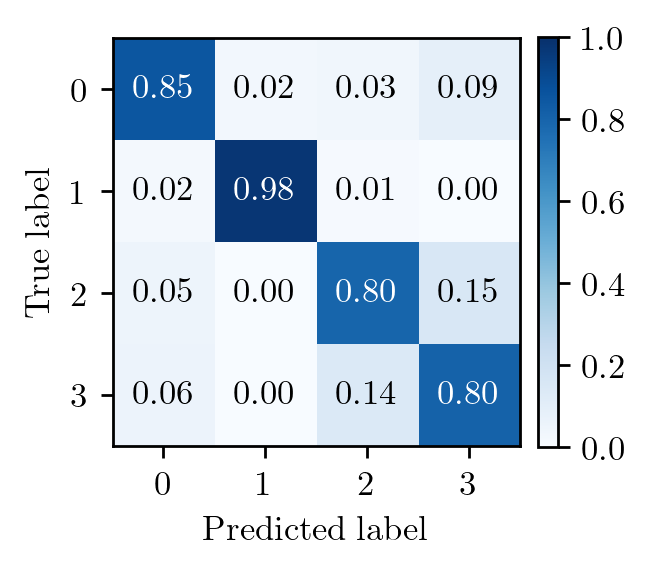

Accuracy RF: 0.8536585365853658
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        34
           1       0.96      1.00      0.98        26
           2       0.76      0.85      0.80        26
           3       0.82      0.76      0.79        37

    accuracy                           0.85       123
   macro avg       0.86      0.86      0.86       123
weighted avg       0.85      0.85      0.85       123

Jaccard_Score: 0.7513070085141215


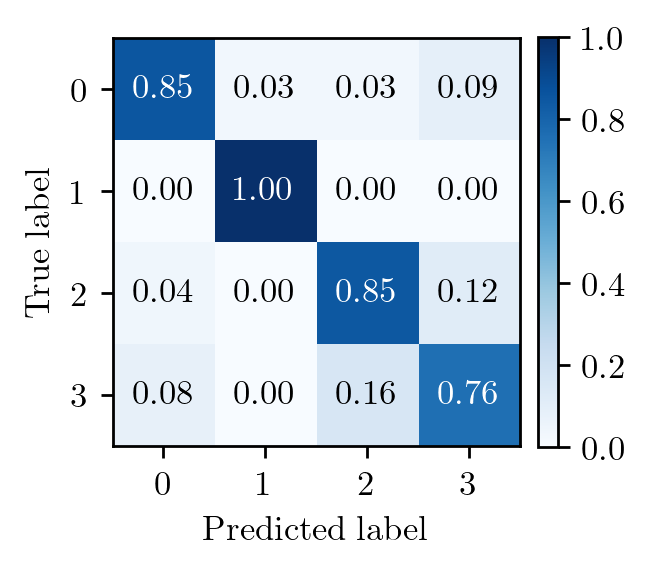

<AxesSubplot: xlabel='$\\mathrm{Predicted\\;label}$', ylabel='$\\mathrm{True\\;label}$'>

In [9]:
index_knn = 1
train_df=train_df_hue
labels=labels_hue

train_features, test_features, train_labels, test_labels = train_test_split(train_df_hue, labels_hue, test_size = 0.25, random_state = 42)

# Solve Optimization IDX process

#index_knn=find_idx_KNN(train_df , labels, use_k_fold=True)

if DEBUG: print(f"KNN IDX = {index_knn}")

# Create KNN classifier
model = KNeighborsClassifier(n_neighbors = index_knn)
# Fit the classifier to the data
model.fit(train_features, train_labels)


## Predicted probabilities

pred_prob=model.predict_proba(test_features)

predictions = model.predict(test_features)

print("acc, f1:",kfold_stats(train_df,labels,model,k_fold=10))

actual_classes, predicted_classes, predicted_proba = kfold_predict(train_df,labels,model,k_fold=10)

fig, ax = plt.subplots(figsize=(2.3,2.3),dpi=250) 

plot_confusion_matrix(actual_classes,predicted_classes, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)


# Use the forest's predict method on the test data
print("Accuracy RF:", metrics.accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("Jaccard_Score:", jaccard_score(test_labels, predictions, average='weighted'))


fig, ax = plt.subplots(figsize=(2.3,2.3),dpi=250) 

plot_confusion_matrix(test_labels,predictions, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)

RF IDX = 90
acc, f1: (0.8659183673469387, 0.8658238670899314)


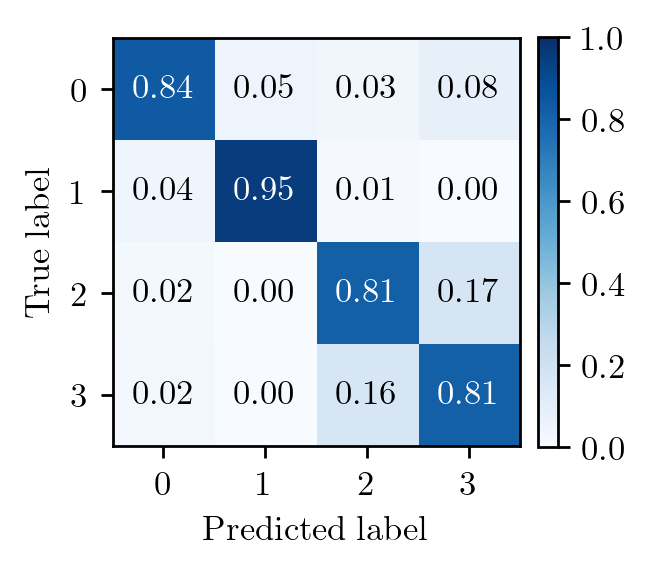

/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy RF: 0.983739837398374
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       0.96      0.96      0.96        26
           3       0.97      0.97      0.97        37

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123

Jaccard_Score: 0.9685098020570849


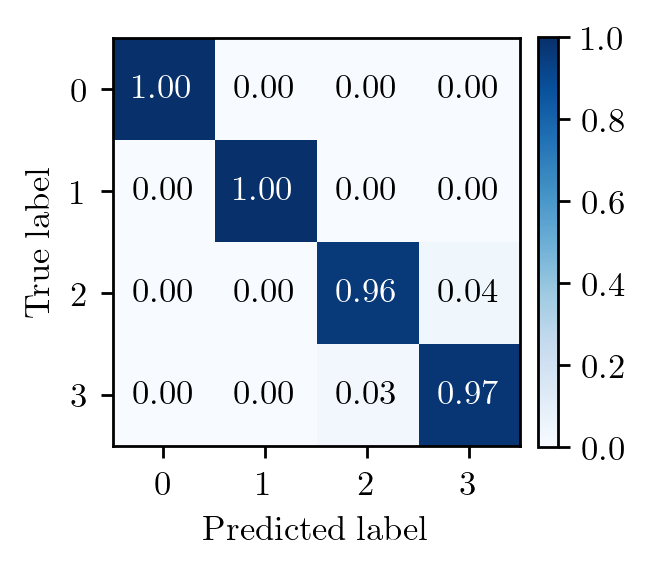

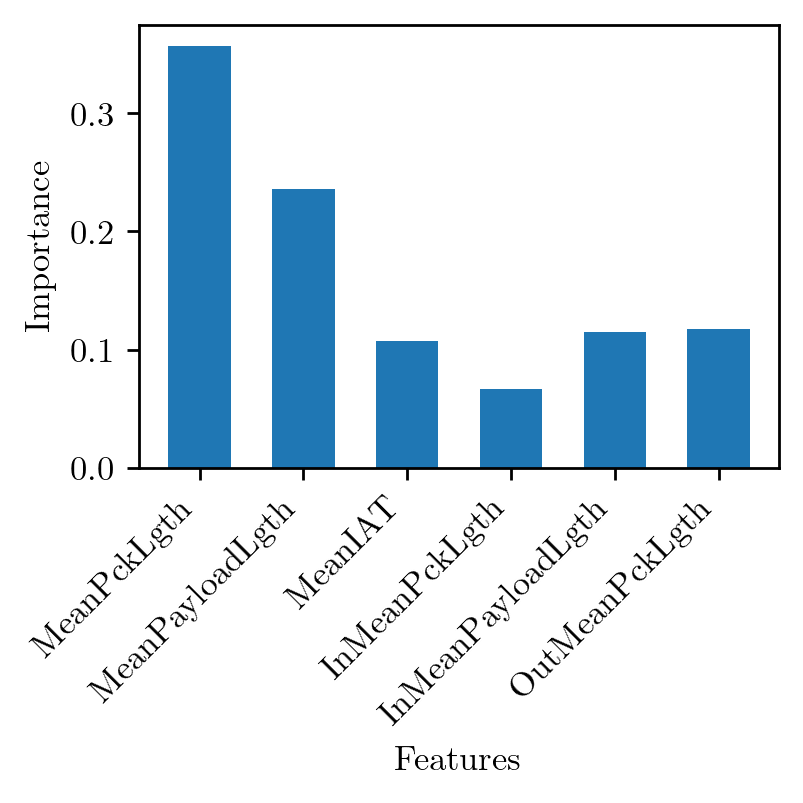

In [12]:
train_df = train_df_hue
labels = labels_hue

index_rf = 90 #9 #90

train_features, test_features, train_labels, test_labels = train_test_split(train_df_hue, labels_hue, test_size = 0.25, random_state = 42)

# Solve Optimization IDX process
#index_rf=find_idx_RF(train_df , labels, use_k_fold=True)

if DEBUG: print(f"RF IDX = {index_rf}")


model = RandomForestClassifier(n_estimators=index_rf, random_state=82)
model.fit(train_features, train_labels)

#Print Kfols_stats
print("acc, f1:",kfold_stats(train_df,labels,model,k_fold=10))


actual_classes, predicted_classes, predicted_proba = kfold_predict(train_df,labels,model,k_fold=10)

fig, ax = plt.subplots(figsize=(2.3,2.3),dpi=250) 

plot_confusion_matrix(actual_classes,predicted_classes, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)

## Predicted probabilities

pred_prob=model.predict_proba(test_features)

predictions = model.predict(test_features)



# Use the forest's predict method on the test data
print("Accuracy RF:", metrics.accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("Jaccard_Score:", jaccard_score(test_labels, predictions, average='weighted'))


fig, ax = plt.subplots(figsize=(2.3, 2.3),dpi=250) 

plot_confusion_matrix(test_labels,predictions, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)


##Feature Importance
fig, ax = plt.subplots(figsize=(3.3, 2.3),dpi=250) 

feat_importance=list(zip(train_features, model.feature_importances_))

plot_feat_bar(feat_importance,ax)



RF IDX = 90
acc, f1: (0.7905125195618153, 0.7901501666671477)


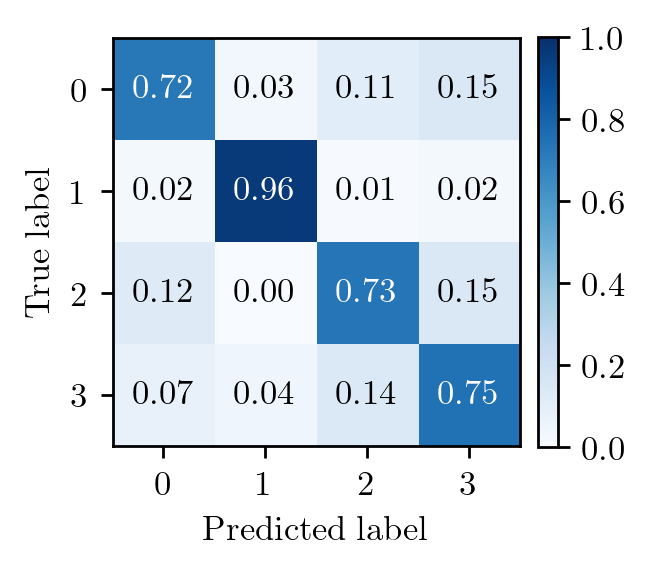

/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/antonio/home-assistant-core/venv/lib/python3.10/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy RF: 0.9162011173184358
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        51
           1       0.91      0.93      0.92        46
           2       1.00      0.93      0.97        46
           3       0.84      0.89      0.86        36

    accuracy                           0.92       179
   macro avg       0.91      0.92      0.91       179
weighted avg       0.92      0.92      0.92       179

Jaccard_Score: 0.8484996009577014


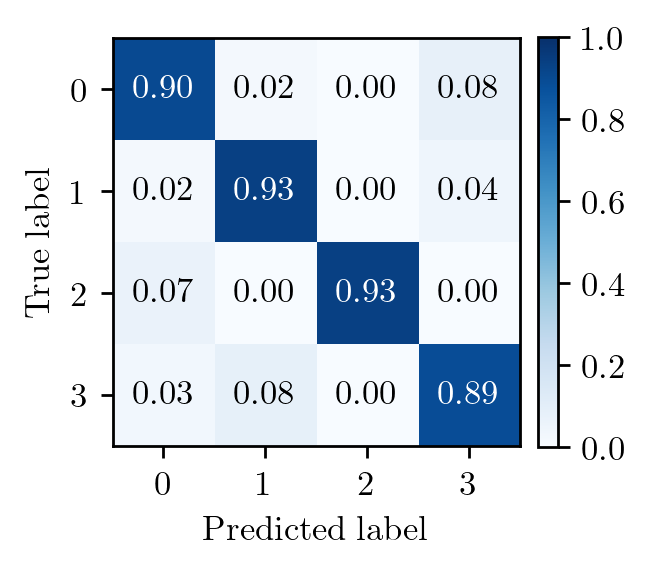

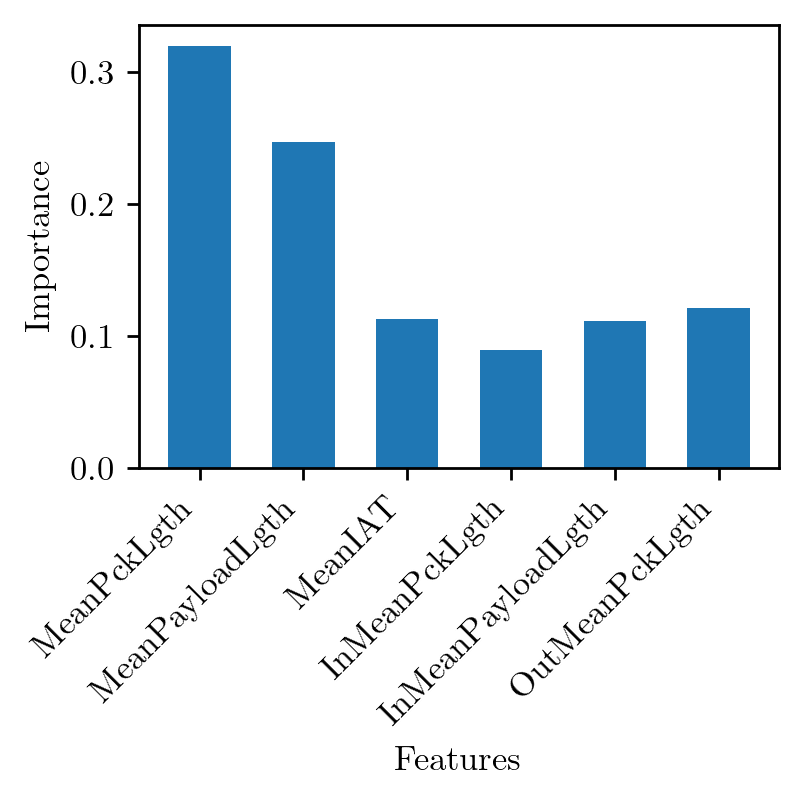

In [11]:
train_df = pd.concat([train_df_hue,train_df_sonoff])
labels = pd.concat([labels_hue, labels_sonoff])

train_features, test_features, train_labels, test_labels = train_test_split(train_df, labels, test_size = 0.25, random_state = 42)

index_rf = 90 #9 #90

# Solve Optimization IDX process
#index_rf=find_idx_RF(train_df , labels, use_k_fold=False)

if DEBUG: print(f"RF IDX = {index_rf}")


model = RandomForestClassifier(n_estimators=index_rf, random_state=82)
model.fit(train_features, train_labels)

#Print Kfols_stats
print("acc, f1:",kfold_stats(train_df,labels,model,k_fold=10))


actual_classes, predicted_classes, predicted_proba = kfold_predict(train_df,labels,model,k_fold=10)

fig, ax = plt.subplots(figsize=(2.3,2.3),dpi=250) 

plot_confusion_matrix(actual_classes,predicted_classes, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)

## Predicted probabilities

pred_prob=model.predict_proba(test_features)

predictions = model.predict(test_features)



# Use the forest's predict method on the test data
print("Accuracy RF:", metrics.accuracy_score(test_labels, predictions))
print(classification_report(test_labels, predictions))
print("Jaccard_Score:", jaccard_score(test_labels, predictions, average='weighted'))


fig, ax = plt.subplots(figsize=(2.3, 2.3),dpi=250) 

plot_confusion_matrix(test_labels,predictions, normalize=True, classes=model.classes_ ,ax=ax,fig=fig)


##Feature Importance
fig, ax = plt.subplots(figsize=(3.3, 2.3),dpi=250) 

feat_importance=list(zip(train_features, model.feature_importances_))

plot_feat_bar(feat_importance,ax)

